<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Previsión de demanda mediante uso de técnicas de machine learning
</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Carlos Pérez Cebrián</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# ARIMA (AutoRegressive Integrated Moving Average)

Modelo estadístico utilizado en el análisis de series temporales para predecir futuros puntos de datos. Es especialmente útil para datos que muestran patrones de autocorrelación y tendencia.

Combina tres componentes:

- AutoRegresivo (p): Relación entre una observación y un número de observaciones anteriores.

- Integrado (d): Involucra la diferenciación de las observaciones para hacer que la serie temporal sea estacionaria.

- Media Móvil (q): Modela el error de predicción como una combinación lineal de errores de predicción pasados.

Los datos de entrada debe ser una serie temporal, ordenados cronológicamente y estacionaria, sino lo fuera se puede aplicar transformaciones como la diferenciación para estabilizar la media y la varianza.

Trabaja con variables continuas, pero no con factores o variables categóricas que deben transformarse previamente. Tampoco tolera los datos nulos. Variables tipo fecha debe estar correctamente formateadas y en orden cronológico.

Para ajustar el modelo: Statsmodels o pmdarima.


Cargamos las siguientes librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller  # Prueba de Dickey-Fuller (ADF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #métricas
from tabulate import tabulate
import matplotlib.pyplot as plt

Cargar el conjunto de datos
(Nota: el conjunto de datos es el resultado de una fase de exploración, analisis y preparación previa.)

In [2]:
# 1. Cargar el archivo de datos
file_path = "Data/VentasRdo.csv"
df = pd.read_csv(file_path, parse_dates=['idSecuencia'])
df = df.sort_values("idSecuencia")

In [3]:
# Filtrar un producto (ejemplo: producto 1)
producto_id = 1
df_producto = df[df['producto'] == producto_id].copy()

#índice temporal (idSecuencia) y frecuencia diaria
df_producto.set_index("idSecuencia", inplace=True)
df_producto = df_producto.asfreq('D')

#revisar que no exista NA (los creará si falta un día)
print(df.isnull().sum())

producto         0
idSecuencia      0
udsVenta         0
bolOpen          0
EnPromocion      0
anyomes          0
diasemana        0
semana           0
media_7_dias     0
media_30_dias    0
venta_lag_1      0
venta_lag_7      0
venta_lag_30     0
dtype: int64


In [4]:
#Verificar la estacionariedad de la serie temporal
#Usa la prueba de Dickey-Fuller aumentada (ADF)
result = adfuller(df_producto['udsVenta'])
print("p-value de ADF:", result[1])
#p-value > 0.05, no es estacionaria
#p-value < 0.05, estacionaria

p-value de ADF: 0.00017894981754452163


El valor p de la prueba de Dickey-Fuller aumentada (ADF) es menor a 0.05, la serie es estacionaria.
La serie temporal no presenta una tendencia significativa ni una varianza cambiante que requiera transformación.
Valor d=0, Integrado (d): Involucra la diferenciación de las observaciones para hacer que la serie temporal sea estacionaria.

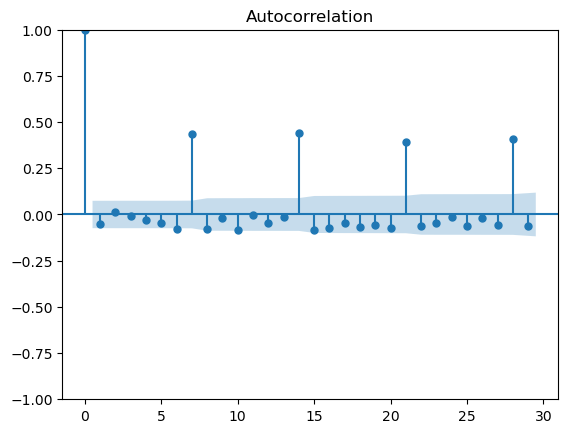

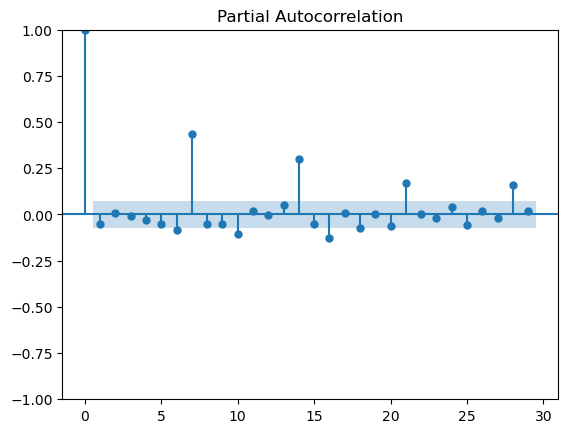

In [5]:
#verificar visualmente la estacionalidad
plot_acf(df_producto['udsVenta'])
plot_pacf(df_producto['udsVenta'])
plt.show()

In [6]:
# 2. Trabajar con udsVenta como serie temporal
serie = df_producto["udsVenta"]

# 3. Dividir en entrenamiento y prueba
train_size = int(len(serie) * 0.8)
train, test = serie[:train_size], serie[train_size:]

In [7]:
# Encontrar los mejores parámetros automáticamente
auto_model = auto_arima(train, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)

# Obtener los valores óptimos de p, d, q
p, d, q = auto_model.order
print(f"Parámetros óptimos: p={p}, d={d}, q={q}")

# Crear y entrenar el modelo ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()  # No se usa maxiter aquí

# Resumen del modelo ajustado
print(model_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2422.006, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2018.389, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2224.397, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1889.922, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1841.083, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1819.460, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1808.548, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1705.291, Time=0.76 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1704.798, Time=0.74 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1702.874, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1701.006, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1701.054, Time=0.39 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1

C:\Users\carpe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- AR (p = 3): El modelo utiliza las últimas 3 observaciones de las ventas para explicar la demanda actual.

- Diferenciación (d = 0): El modelo no aplica diferenciación, sugiriendo que los datos ya son estacionarios tras aplicar el logaritmo.

- MA (q = 5): El modelo incluye términos de media móvil de orden 5, incorporando efectos de ruido pasados.


In [8]:
# Ajustar el modelo ARIMA con los parámetros óptimos
model = ARIMA(train, order=(3, 0, 5))
model_fit = model.fit()

# Resumen del modelo ajustado
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               udsVenta   No. Observations:                  560
Model:                 ARIMA(3, 0, 5)   Log Likelihood                -798.029
Date:                Sun, 15 Dec 2024   AIC                           1616.059
Time:                        10:27:42   BIC                           1659.338
Sample:                    12-06-2022   HQIC                          1632.958
                         - 06-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7805      0.044     40.077      0.000       1.693       1.868
ar.L1          0.2793      0.023     11.969      0.000       0.234       0.325
ar.L2          0.2027      0.029      7.059      0.0

C:\Users\carpe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# Predecir el conjunto de prueba
forecast = model_fit.forecast(steps=len(test))
predictions = pd.Series(forecast, index=test.index)



In [10]:
# Evaluar las métricas de error
arima_305_rmse = np.sqrt(mean_squared_error(test, predictions))
arima_305_mse = mean_squared_error(test, predictions)
arima_305_mae = mean_absolute_error(test, predictions)
arima_305_r2 = r2_score(test, predictions)
arima_305_mape = np.mean(np.abs((test - predictions) / test)) * 100


print("Resultado para Arima(3,0,5)")
print(f"RMSE: {arima_305_rmse:.4f} (evalúa el ajuste del modelo en general)")
print(f"MSE: {arima_305_mse:.4f}")
print(f"MAE:  {arima_305_mae:.4f} (error absoluto promedio en la predicción. Robusto frente a outliers)")
print(f"R2: {arima_305_r2:.4f}")
print(f"MAPE: {arima_305_mape:.2f}% ")

Resultado para Arima(3,0,5)
RMSE: 1.0264 (evalúa el ajuste del modelo en general)
MSE: 1.0536
MAE:  0.8733 (error absoluto promedio en la predicción. Robusto frente a outliers)
R2: 0.0815
MAPE: inf% 


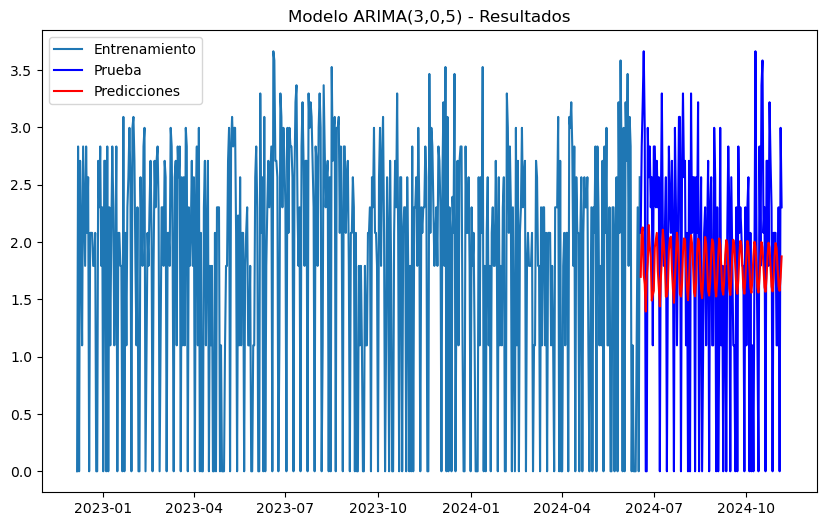

In [11]:
# 7. Visualización de resultados
# Gráfico de las predicciones frente a los datos reales
plt.figure(figsize=(10, 6))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Prueba", color="blue")
plt.plot(predictions, label="Predicciones", color="red")
plt.legend()
plt.title("Modelo ARIMA(3,0,5) - Resultados")
plt.show()

In [12]:
# Ajustar el modelo ARIMA con los parámetros óptimos
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

# Resumen del modelo ajustado
print(model_fit.summary())

# Predecir en el conjunto de prueba
forecast = model_fit.forecast(steps=len(test))
predictions = pd.Series(forecast, index=test.index)

# Evaluar las métricas de error
arima_101_rmse = np.sqrt(mean_squared_error(test, predictions))
arima_101_mse  = mean_squared_error(test, predictions)
arima_101_mae  = mean_absolute_error(test, predictions)
arima_101_r2   = r2_score(test, predictions)
arima_101_mape = np.mean(np.abs((test - predictions) / test)) * 100

print("Arima(1,0,1)")
print(f"RMSE: {arima_101_rmse:.4f} (evalúa el ajuste del modelo en general)")
print(f"MSE: {arima_101_mse:.4f}")
print(f"MAE: {arima_101_mae:.4f} (error absoluto promedio en la predicción. Robusto frente a outliers)")
print(f"R2: {arima_101_r2:.4f}")
print(f"MAPE: {arima_101_mape:.2f}% ")

                               SARIMAX Results                                
Dep. Variable:               udsVenta   No. Observations:                  560
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -842.569
Date:                Sun, 15 Dec 2024   AIC                           1693.137
Time:                        10:27:43   BIC                           1710.449
Sample:                    12-06-2022   HQIC                          1699.897
                         - 06-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7942      0.055     32.409      0.000       1.686       1.903
ar.L1         -0.3305      0.780     -0.424      0.672      -1.859       1.198
ma.L1          0.2836      0.792      0.358      0.7

Resultado para Arima(3,0,5)
RMSE: 1.0279 (evaluar el ajuste del modelo en general)
MAE: 0.8736 (error absoluto promedio en la predicción. Este valor es más robusto frente a outliers)
MAPE: inf% 
    
Arima(1,0,1)
RMSE: 1.0723 (evaluar el ajuste del modelo en general)
MAE: 0.8979 (error absoluto promedio en la predicción. Este valor es más robusto frente a outliers)
MAPE: inf% 
    


Evaluar con un modelo línea base

In [13]:
# Cargar datos y preparar el dataset
file_path = "Data/VentasRdo.csv"
df = pd.read_csv(file_path, parse_dates=['idSecuencia'])
df = df.sort_values("idSecuencia")

# Filtrar un producto específico (ejemplo: producto 1)
producto_id = 1
df_producto = df[df['producto'] == producto_id].copy()

# Índice temporal (idSecuencia) y frecuencia diaria
df_producto.set_index("idSecuencia", inplace=True)
df_producto = df_producto.asfreq('D')

# Verificar valores nulos (pueden surgir por frecuencias)
print(df_producto.isnull().sum())

# Dividir en entrenamiento y prueba
train_size = int(len(df_producto) * 0.8)
train = df_producto.iloc[:train_size]
test = df_producto.iloc[train_size:]

producto         0
udsVenta         0
bolOpen          0
EnPromocion      0
anyomes          0
diasemana        0
semana           0
media_7_dias     0
media_30_dias    0
venta_lag_1      0
venta_lag_7      0
venta_lag_30     0
dtype: int64


In [14]:
# Verdadero valor de test
true_values = test["udsVenta"]

# 1. Promedio móvil de los últimos 7 días (media_7_dias)
rmse_media_7 = mean_squared_error(true_values, test["media_7_dias"], squared=False)
mse_media_7  = mean_squared_error(true_values, test["media_7_dias"])
mae_media_7  = mean_absolute_error(true_values, test["media_7_dias"])
r2_media_7   = r2_score(true_values, test["media_7_dias"])
print(f"Promedio móvil (7 días) - RMSE: {rmse_media_7:.4f}, MSE: {mse_media_7:.4f}, MAE: {mae_media_7:.4f}, R2: {r2_media_7:.4f}")

# 2. Promedio móvil de los últimos 30 días (media_30_dias)
rmse_media_30 = mean_squared_error(true_values, test["media_30_dias"], squared=False)
mse_media_30  = mean_squared_error(true_values, test["media_30_dias"])
mae_media_30  = mean_absolute_error(true_values, test["media_30_dias"])
r2_media_30   = r2_score(true_values, test["media_30_dias"])
print(f"Promedio móvil (30 días) - RMSE: {rmse_media_30:.4f}, MSE: {mse_media_30:.4f}, MAE: {mae_media_30:.4f}, R2: {r2_media_30:.4f}")

# 3. Último valor observado (venta_lag_1)
rmse_venta_lag_1 = mean_squared_error(true_values, test["venta_lag_1"], squared=False)
mse_venta_lag_1  = mean_squared_error(true_values, test["venta_lag_1"])
mae_venta_lag_1  = mean_absolute_error(true_values, test["venta_lag_1"])
r2_venta_lag_1   = r2_score(true_values, test["venta_lag_1"])
print(f"Último valor observado (lag 1) - RMSE: {rmse_venta_lag_1:.4f}, MSE: {mse_venta_lag_1:.4f}, MAE: {mae_venta_lag_1:.4f}, R2: {r2_venta_lag_1:.4f}")

# 4. Valor observado hace 7 días (venta_lag_7)
rmse_venta_lag_7 = mean_squared_error(true_values, test["venta_lag_7"], squared=False)
mse_venta_lag_7  = mean_squared_error(true_values, test["venta_lag_7"])
mae_venta_lag_7  = mean_absolute_error(true_values, test["venta_lag_7"])
r2_venta_lag_7   = r2_score(true_values, test["venta_lag_7"])
print(f"Valor observado (lag 7 días) - RMSE: {rmse_venta_lag_7:.4f}, MSE: {mse_venta_lag_7:.4f}, MAE: {mae_venta_lag_7:.4f}, R2: {r2_venta_lag_7:.4f}")

# 5. Valor observado hace 30 días (venta_lag_30)
rmse_venta_lag_30 = mean_squared_error(true_values, test["venta_lag_30"], squared=False)
mse_venta_lag_30  = mean_squared_error(true_values, test["venta_lag_30"])
mae_venta_lag_30  = mean_absolute_error(true_values, test["venta_lag_30"])
r2_venta_lag_30   = r2_score(true_values, test["venta_lag_30"])
print(f"Valor observado (lag 30 días) - RMSE: {rmse_venta_lag_30:.4f}, MSE: {mse_venta_lag_30:.4f}, MAE: {mae_venta_lag_30:.4f}, R2: {r2_venta_lag_30:.4f}")

Promedio móvil (7 días) - RMSE: 1.0259, MSE: 1.0524, MAE: 0.8260, R2: 0.0825
Promedio móvil (30 días) - RMSE: 1.0468, MSE: 1.0959, MAE: 0.8691, R2: 0.0446
Último valor observado (lag 1) - RMSE: 1.5823, MSE: 2.5037, MAE: 1.2784, R2: -1.1827
Valor observado (lag 7 días) - RMSE: 1.1126, MSE: 1.2379, MAE: 0.7827, R2: -0.0792
Valor observado (lag 30 días) - RMSE: 1.5593, MSE: 2.4313, MAE: 1.2219, R2: -1.1196


In [15]:
# Comparación general
resultados = [
    ['ARIMA 3.0.5', arima_305_rmse, arima_305_mse, arima_305_mae, arima_305_r2],
    ['ARIMA 1.0.1', arima_101_rmse, arima_101_mse, arima_101_mae, arima_101_r2],
    ['Media 7 días' , rmse_media_7 , mse_media_7 , mae_media_7 , r2_media_7],
    ['Media 30 días', rmse_media_30, mse_media_30, mae_media_30, r2_media_30],
    ['Último valor observado (lag 1)', rmse_venta_lag_1 , mse_venta_lag_1 , mae_venta_lag_1 , r2_venta_lag_1],
    ['Valor observado (lag 7 días)'  , rmse_venta_lag_7 , mse_venta_lag_7 , mae_venta_lag_7 , r2_venta_lag_7],
    ['Valor observado (lag 30 días)' , rmse_venta_lag_30, mse_venta_lag_30, mae_venta_lag_30, r2_venta_lag_30]
]

# encabezado de la tabla
encabezado = ['Modelo', 'RMSE', 'MSE', 'MAE', 'R2']

# orden
resultados_ordenados = sorted(resultados, key=lambda x: x[1])

# tabla
tabla = tabulate(resultados_ordenados, headers=encabezado, tablefmt='pipe', floatfmt=".4f")
print(tabla)

| Modelo                         |   RMSE |    MSE |    MAE |      R2 |
|:-------------------------------|-------:|-------:|-------:|--------:|
| Media 7 días                   | 1.0259 | 1.0524 | 0.8260 |  0.0825 |
| ARIMA 3.0.5                    | 1.0264 | 1.0536 | 0.8733 |  0.0815 |
| Media 30 días                  | 1.0468 | 1.0959 | 0.8691 |  0.0446 |
| ARIMA 1.0.1                    | 1.0723 | 1.1498 | 0.8979 | -0.0024 |
| Valor observado (lag 7 días)   | 1.1126 | 1.2379 | 0.7827 | -0.0792 |
| Valor observado (lag 30 días)  | 1.5593 | 2.4313 | 1.2219 | -1.1196 |
| Último valor observado (lag 1) | 1.5823 | 2.5037 | 1.2784 | -1.1827 |


Los modelos _"Media 7 días"_ y _"ARIMA 3.0.5"_ son los que tienen menor RMSE y un MAE, practicamente iguales y relativamente bajo, por lo que, son con los que mejor predicciones se obtendrá. 

A pesar de ser un modelo sencillo, utilizar las medias de los últimos 7 días para hacer las predicciones parece ser una buena aproximación.
